## AI Deepfake Detection - EDA

## Imports

In [3]:
import pandas as pd
import json
import os
from IPython.display import Video

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os 
import ffmpeg

import cv2
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision import models, transforms
import torch
from matplotlib.colors import to_rgba
from mpl_toolkits.mplot3d import Axes3D

### Exploratory Data Analysis (EDA)
In this section, we conducted a thorough exploratory data analysis (EDA) to understand the structure and patterns in the dataset used for deepfake video detection. Below are the key steps and insights:

### 1. Data Overview and Metadata Loading
We first start by loading the sample dataset. For this initial portion of EDA, we will use this sample dataset to analyse the distribution of the dataset.

In [4]:
# Helper functions to load data/video
def load_metadata(metadata_path):
    """Load metadata from a JSON file and return a DataFrame."""
    with open(metadata_path) as f:
        metadata = json.load(f)
    df = pd.DataFrame.from_dict(metadata, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'video_filename'}, inplace=True)
    return df

def play_video(video_filename, video_folder='../data/train_sample_videos'):
    """Play a video given its filename."""
    video_path = os.path.join(video_folder, video_filename)
    if os.path.exists(video_path):
        return Video(video_path,width=320, height=320)
    else:
        print(f"Video file {video_filename} does not exist.")

In [5]:
## Load the training and test set
train_metadata_path = '../data/train_sample_videos/metadata.json'
train_metadata_df = load_metadata(train_metadata_path)
train_metadata_df

,video_filename,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4
...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
398,eudeqjhdfd.mp4,REAL,train,None


A simple bar chart reveals that the majority of the dataset consist of fake videos, accounting for approximately 80% of the dataset.

In [4]:
# Distribution of real vs fake
def plot_label_distribution(df):
    """Plot the percentage distribution of real and fake videos, showing both percentage and raw counts."""

    # Calculate the raw counts and percentages
    label_counts = df['label'].value_counts()
    label_percentages = df['label'].value_counts(normalize=True) * 100

    # Create a DataFrame to combine both counts and percentages
    label_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages})

    # Plot the counts
    plt.figure(figsize=(6, 6))
    ax = sns.barplot(hue=label_df.index, x=label_df.index, 
                     y=label_df['Count'], palette='coolwarm',
                     legend=False)

    # Add labels with both raw counts and percentages
    for i in ax.containers:
        ax.bar_label(i, labels=[f'{v.get_height():,.0f} ({v.get_height()/label_counts.sum()*100:.1f}%)' for v in i])

    # Set plot titles and labels
    plt.title('Distribution of Real vs Fake Videos')
    plt.xlabel('Video Label')
    plt.ylabel('Count')
    plt.show()

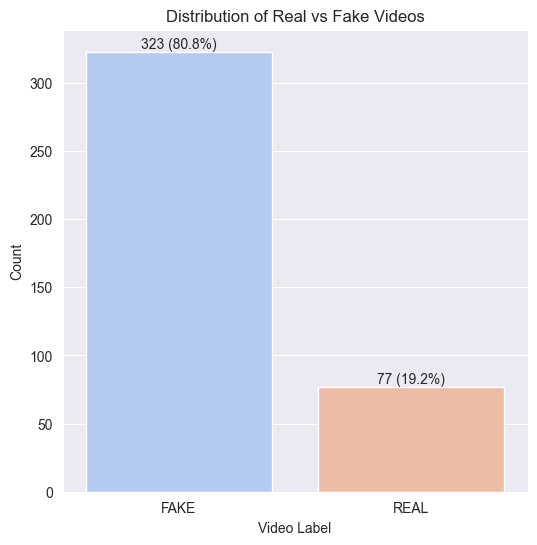

In [5]:
plot_label_distribution(train_metadata_df)

Currently, the metadata file is quite limited, only telling us the video name and the label of the video, which will help us in training our model. However, we also want to take a look at metadata about the videos themselves, so we will write some code to get this information out. 

The features that we will extract include:
- Duration
- Frame Rate
- Resolution
- Codec
- File Size

In [6]:
def get_video_metadata(video_path):
    """Extract metadata from a video using ffmpeg."""
    try:
        probe = ffmpeg.probe(video_path)
        video_info = next(stream for stream in probe['streams'] if stream['codec_type'] == 'video')

        # Extracting relevant metadata
        duration = float(probe['format']['duration'])  # Duration in seconds
        frame_rate = eval(video_info['r_frame_rate'])  # Frames per second
        width = int(video_info['width'])  # Video width
        height = int(video_info['height'])  # Video height
        codec = video_info['codec_name']  # Codec used to encode the video
        file_size = int(probe['format']['size'])  # File size in bytes

        return {
            'duration': duration,
            'frame_rate': frame_rate,
            'resolution': f"{width}x{height}",
            'codec': codec,
            'file_size': file_size
        }
    except Exception as e:
        print(f"Error retrieving metadata for {video_path}: {e}")
        return None

def get_all_videos_metadata(df, video_dir):
    """Extract metadata for all videos in the DataFrame and add it as new columns."""
    metadata_list = []

    for video_name in df['video_filename']:
        video_path = os.path.join(video_dir, video_name)
        metadata = get_video_metadata(video_path)
        if metadata:
            metadata_list.append(metadata)
        else:
            metadata_list.append({'duration': None, 'frame_rate': None, 'resolution': None, 'codec': None, 'file_size': None})

    # Add the extracted metadata to the DataFrame
    metadata_df = pd.DataFrame(metadata_list)
    df = pd.concat([df.reset_index(drop=True), metadata_df.reset_index(drop=True)], axis=1)

    return df

In [7]:
train_video_path = '../data/train_sample_videos'
train_metadata_df = get_all_videos_metadata(train_metadata_df, train_video_path)
train_metadata_df

,video_filename,label,split,original,duration,frame_rate,resolution,codec,file_size
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,10.022,29.970,1920x1080,h264,10922046
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,10.022,29.970,1920x1080,h264,4472228
2,abarnvbtwb.mp4,REAL,train,None,10.022,29.970,1920x1080,h264,5032214
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,10.022,29.970,1920x1080,h264,2796925
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,10.022,29.970,1920x1080,h264,3513304
...,...,...,...,...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,10.022,29.970,1920x1080,h264,5265699
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,10.024,29.969,1080x1920,h264,3441035
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,10.022,29.970,1920x1080,h264,8627946
398,eudeqjhdfd.mp4,REAL,train,None,10.022,29.970,1920x1080,h264,7169947


Now that we have these new features, let's visualize these features.

In [9]:
def plot_codec_distribution(df, ax):
    """Plot the distribution of video codecs."""
    sns.countplot(hue = 'codec', x='codec', data=df, palette='Set2', ax=ax, legend=False)
    ax.set_title('Distribution of Video Codecs')
    ax.set_xlabel('Video Codec')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

def plot_frame_rate_distribution(df, ax):
    """Plot the distribution of video frame rates."""
    sns.histplot(df['frame_rate'], kde=True, bins=20, color='purple', ax=ax)
    ax.set_title('Distribution of Frame Rates')
    ax.set_xlabel('Frame Rate (FPS)')
    ax.set_ylabel('Frequency')

def plot_resolution_distribution(df, ax):
    """Plot the distribution of video resolutions."""
    sns.countplot(hue = 'resolution', y='resolution', data=df, palette='coolwarm', ax=ax, order=df['resolution'].value_counts().index, legend=False)
    ax.set_title('Distribution of Video Resolutions')
    ax.set_xlabel('Count')
    ax.set_ylabel('Resolution')

def plot_file_size_distribution(df, ax):
    """Plot the distribution of video file sizes."""
    sns.histplot(df['file_size'] / (1024 * 1024), kde=True, bins=20, color='green', ax=ax)  # Convert file size from bytes to MB
    ax.set_title('Distribution of Video File Sizes')
    ax.set_xlabel('File Size (MB)')
    ax.set_ylabel('Frequency')

def plot_combined_video_metadata(df):
    """Plot video metadata distributions in subplots using existing functions."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Video Metadata Distributions', fontsize=16)

    # 1. Video Codec Distribution
    plot_codec_distribution(df, axes[0, 0])

    # 2. Frame Rate Distribution
    plot_frame_rate_distribution(df, axes[0, 1])

    # 3. Resolution Distribution
    plot_resolution_distribution(df, axes[1, 0])

    # 4. File Size Distribution
    plot_file_size_distribution(df, axes[1, 1])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for the title
    plt.show()

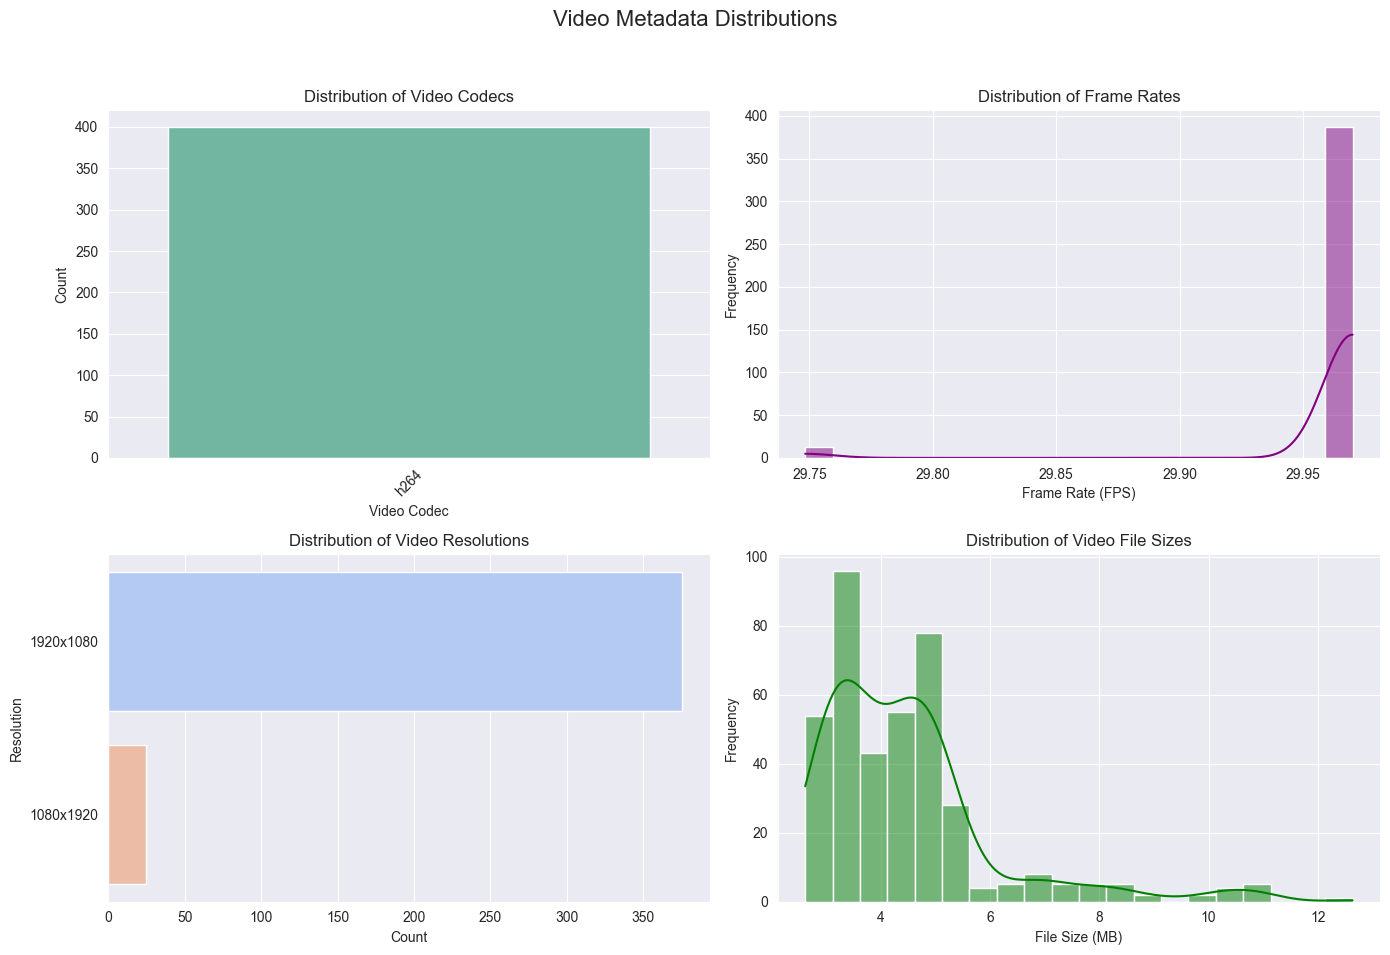

In [10]:
plot_combined_video_metadata(train_metadata_df)

From the above, we can tell that the dataset is pretty clean, with all of them being in the same codec format. The frame rates are consistent at around 29 as well. On the other hand, majority of the dataset have resolutions of 1920 x 1080, whilst the file sizes are between 2MB to 6MB.

Given these preliminary EDA, we will now dive into the videos themselves, with the aim of trying to identify what differentiates a real video from a fake video.

### Analyzing Frame Dissimilarity
We will first use the frame dissimilarity to compare consecutive frames within the videos. By measuring how much change occurs between adjacent frames, we hope to see a different distribution between the real and the fake videos, possible caused by artifacts introduced by the generation model.

In [16]:
def extract_frames(video_path):
    """Extract frames from a video and return them as a list of numpy arrays."""
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame to grayscale for easier processing
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()
    return frames

def compute_frame_differences(frames):
    """Compute pixel-wise differences between consecutive frames."""
    frame_diffs = []

    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])
        frame_diffs.append(np.sum(diff))  # Sum of pixel differences

    return frame_diffs

def analyze_videos(df, video_dir):
    """Analyze frame dissimilarity for all videos in the dataset."""
    results = {"video": [], "label": [], "mean_frame_diff": []}

    for idx, row in df.iterrows():
        video_file = row['video_filename']
        video_label = row['label']
        video_path = os.path.join(video_dir, video_file)

        # Extract frames and compute frame differences
        frames = extract_frames(video_path)
        if len(frames) < 2:
            continue  # Skip videos with too few frames

        frame_diffs = compute_frame_differences(frames)
        mean_frame_diff = np.mean(frame_diffs)

        # Store results
        results["video"].append(video_file)
        results["label"].append(video_label)
        results["mean_frame_diff"].append(mean_frame_diff)

    return results

def plot_frame_dissimilarity_distribution(results):
    """Plot the distribution of frame dissimilarity across all videos."""
    df_results = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='mean_frame_diff', data=df_results, palette='coolwarm')
    plt.title('Frame Dissimilarity Across Videos (Real vs Fake)')
    plt.xlabel('Video Label')
    plt.ylabel('Mean Frame Difference')
    plt.show()

    # You can also plot the distribution using histograms
    plt.figure(figsize=(10, 6))
    sns.histplot(df_results[df_results['label'] == 'FAKE']['mean_frame_diff'], kde=True, color='red', label='FAKE')
    sns.histplot(df_results[df_results['label'] == 'REAL']['mean_frame_diff'], kde=True, color='green', label='REAL')
    plt.title('Distribution of Frame Dissimilarity')
    plt.xlabel('Mean Frame Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

C:\Users\jhau2\AppData\Local\Temp\ipykernel_21364\2841242886.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='mean_frame_diff', data=df_results, palette='coolwarm')


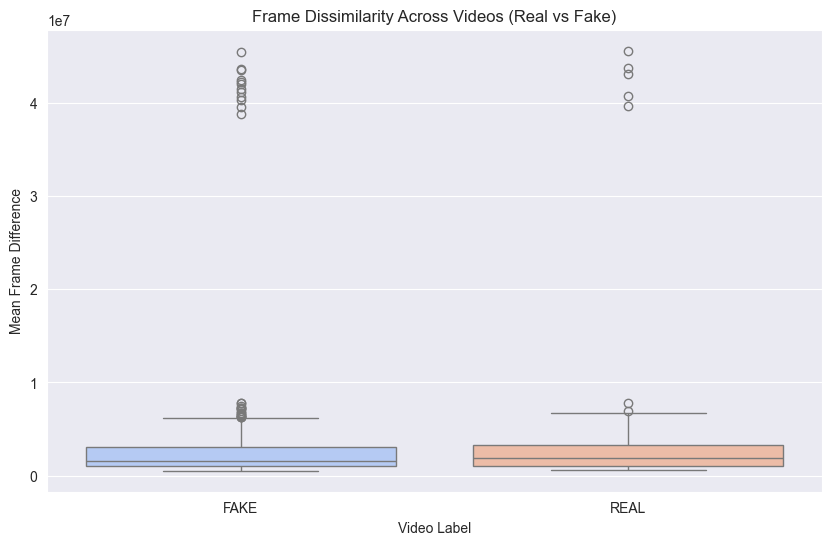

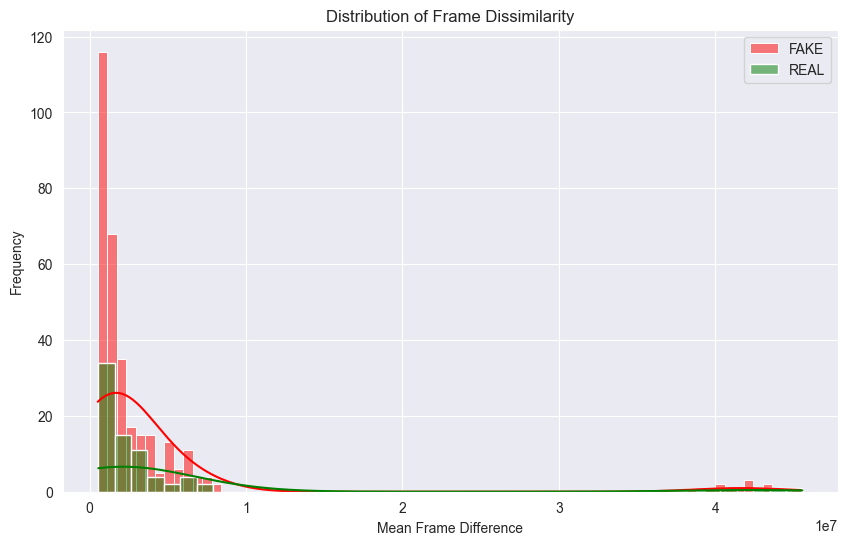

In [17]:
results = analyze_videos(train_metadata_df, train_video_path)
plot_frame_dissimilarity_distribution(results)

As seen from the visualizations above, there seems to be very little difference between the face dissimilarity of the real and fake videos. We note however that in the histogram plot, there is a spike in the frequency counts of fake videos having a mean frame difference of 4 and above. We hypothesize that this is most likely due to the fake videos only altering the faces of people in the videos, which accounts for a small subset of the frames. We therefore proceed to the next technique for analysis, which is the consistency of the face count.

### Face Count Consistency
The goal of this analysis is to examine the consistency in the number of faces detected across frames in each video. This can provide valuable insights, particularly for tasks like deepfake detection. In real videos, the number of faces detected across frames should generally remain stable, reflecting natural and consistent facial appearances. However, fake videos (e.g., deepfakes) may exhibit irregular face counts due to artifacts introduced during the generation process, such as glitches in face swaps or frame mismatches.

In [10]:
# Load the pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_frames(video_path):
    """Extract frames from a video and return them as a list of numpy arrays."""
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)  # Store the original colored frame for face detection

    cap.release()
    return frames

def detect_faces_in_frame(frame):
    """Detect faces in a frame and return the number of faces detected."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert the frame to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return len(faces)  # Return the number of faces detected

def analyze_face_count_per_video(df, video_dir):
    """Analyze face count consistency for all videos in the dataset."""
    results = {"video": [], "label": [], "avg_face_count": []}

    for idx, row in df.iterrows():
        video_file = row['video_filename']
        video_label = row['label']
        video_path = os.path.join(video_dir, video_file)

        # Extract frames from the video
        frames = extract_frames(video_path)
        face_counts = []

        for frame in frames:
            num_faces = detect_faces_in_frame(frame)  # Count faces in each frame
            face_counts.append(num_faces)

        if len(face_counts) > 0:
            avg_face_count = np.mean(face_counts)  # Average face count per video
        else:
            avg_face_count = 0  # If no frames were processed

        # Store the results
        results["video"].append(video_file)
        results["label"].append(video_label)
        results["avg_face_count"].append(avg_face_count)

    return results

def plot_face_count_distribution(results):
    """Plot the distribution of face count consistency across all videos."""
    df_results = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='avg_face_count', data=df_results, palette='coolwarm')
    plt.title('Face Count Consistency Across Videos (Real vs Fake)')
    plt.xlabel('Video Label')
    plt.ylabel('Average Face Count per Frame')
    plt.show()

    # Optionally, you can also visualize the distribution using histograms
    plt.figure(figsize=(10, 6))
    sns.histplot(df_results[df_results['label'] == 'FAKE']['avg_face_count'], kde=True, color='red', label='FAKE')
    sns.histplot(df_results[df_results['label'] == 'REAL']['avg_face_count'], kde=True, color='green', label='REAL')
    plt.title('Distribution of Face Count Consistency')
    plt.xlabel('Average Face Count per Frame')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

C:\Users\jhau2\AppData\Local\Temp\ipykernel_10316\1183694153.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='avg_face_count', data=df_results, palette='coolwarm')


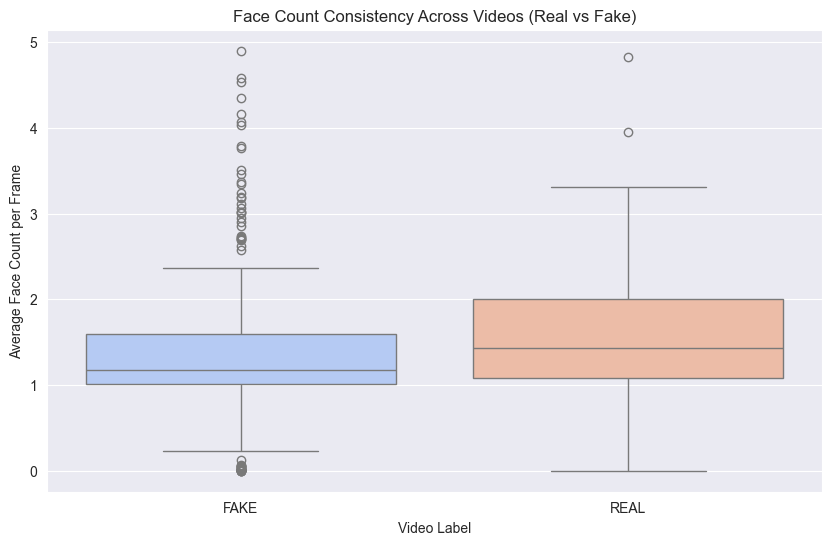

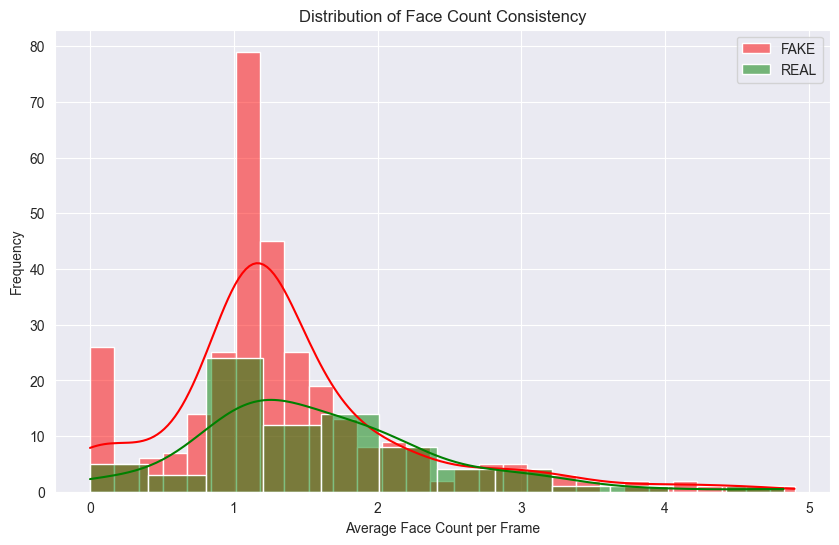

In [11]:
results = analyze_face_count_per_video(train_metadata_df, train_video_path)
plot_face_count_distribution(results)

As we can see from the above, there is a clear difference between the distributions of the real and fake videos, with significantly more outliers in the fake video distribution. We believe this is a result of the face generation algorithm causing differences in the number of face counts.

### Optical Flow Analysis
Lastly, we use optical flow analysis, to examine motion patterns in videos using optical flow. Optical flow measures the movement of pixels between consecutive frames, helping us detect temporal irregularities. In the context of deepfake detection or video authenticity analysis, analyzing optical flow can provide insights into the naturalness or inconsistency of motion, such as facial expressions, eye blinks, or scene transitions.

In [11]:
# Optical flow for a particular video
def extract_frames(video_path):
    """Extract frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def calculate_optical_flow(frames):
    """Calculate dense optical flow between consecutive frames."""
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    flow_magnitudes = []

    for i in range(1, len(frames)):
        current_frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_frame, current_frame, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flow_magnitudes.append(magnitude)
        prev_frame = current_frame

    return np.array(flow_magnitudes)

def visualize_optical_flow_heatmap(magnitudes, video_label, frame_step=10):
    """Visualize optical flow as a heatmap."""
    avg_magnitude = np.mean(magnitudes, axis=0)
    avg_magnitude_normalized = cv2.normalize(avg_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(avg_magnitude_normalized, cmap='coolwarm', cbar=True)
    plt.title(f'Optical Flow Heatmap for {video_label} Video')
    plt.xlabel('Pixel Width')
    plt.ylabel('Pixel Height')
    plt.show()

def analyze_specific_video_optical_flow(df, video_dir, video_filename):
    """Analyze optical flow for a specific video in the dataset."""
    # Retrieve video details from the dataframe
    video_data = df[df['video_filename'] == video_filename].iloc[0]
    video_label = video_data['label']
    video_path = os.path.join(video_dir, video_filename)

    # Extract frames from the video
    frames = extract_frames(video_path)

    # Calculate optical flow
    magnitudes = calculate_optical_flow(frames)

    # Visualize optical flow as a heatmap
    visualize_optical_flow_heatmap(magnitudes, video_label)

    # Optional: return calculated magnitudes for further analysis
    return magnitudes


In the code block below, we select a real video from the sample training dataset, along with a fake video generated from the real one. Upon plotting the optical flow heatmap, we observe that, aside from the hands of the person indicating frequent motion, a significant difference between the heatmaps is evident in the facial region. The fake video exhibits notably higher optical flow in the facial area compared to the real video.

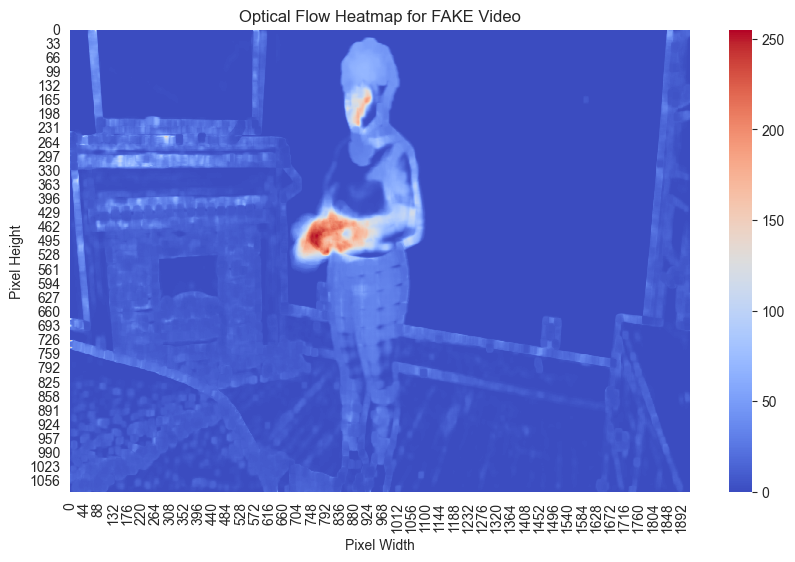

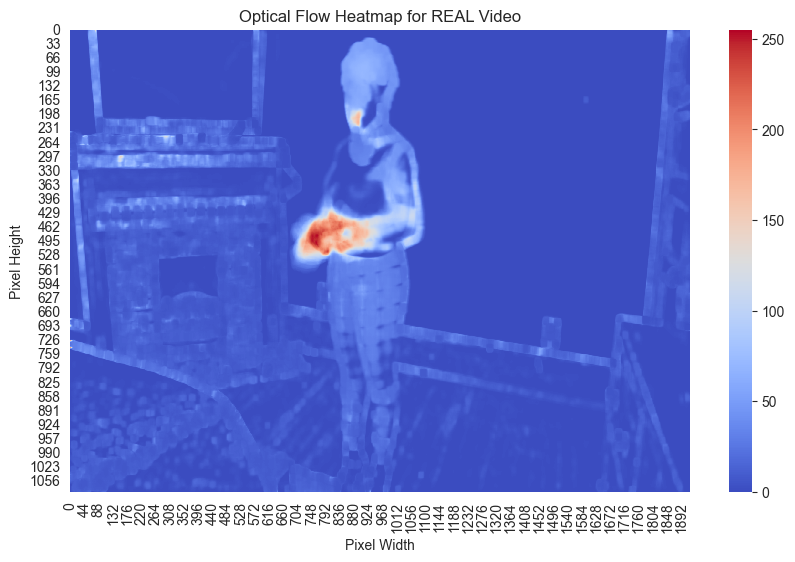

In [21]:
fake_video = "coadfnerlk.mp4"
real_video = "bwipwzzxxu.mp4"
fake_optical = analyze_specific_video_optical_flow(train_metadata_df, train_video_path, fake_video)
real_optical = analyze_specific_video_optical_flow(train_metadata_df, train_video_path, real_video)

We then proceed to apply this optical flow analysis for the entire sample training dataset, with the aim of once again trying to identify if there is a difference in distribution between the real and fake videos.

In [28]:
def extract_frames_with_resize(video_path, resize_factor=0.25, duration=10):
    """Extract frames from a video and resize them, limited by the given duration."""
    cap = cv2.VideoCapture(video_path)
    frames = []

    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # Get frame rate of the video
    total_frames = int(frame_rate * duration)    # Limit the frames to the duration specified

    frame_count = 0
    while cap.isOpened() and frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame
        frame_resized = cv2.resize(frame, None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_LINEAR)
        frames.append(frame_resized)
        frame_count += 1

    cap.release()
    return frames

def calculate_average_flow(magnitudes):
    """Calculate the average optical flow magnitude for a list of magnitude arrays."""
    return np.mean([np.mean(mag) for mag in magnitudes])

def visualize_optical_flow_distribution(df):
    """Visualize the distribution of average optical flow between real and fake videos."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='avg_flow', data=df, palette='coolwarm')
    plt.title('Optical Flow Magnitude Distribution for Real vs Fake Videos')
    plt.xlabel('Video Label')
    plt.ylabel('Average Optical Flow Magnitude')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Updating the process_videos_optical_flow function
def process_videos_optical_flow(df, video_dir, resize_factor=0.25, duration=10):
    """Process all videos in the dataframe to compute average optical flow, limited by duration."""
    flow_data = []
    for idx, row in df.iterrows():
        video_file = row['video_filename']
        video_label = row['label']
        video_path = os.path.join(video_dir, video_file)

        # Extract frames and calculate optical flow
        frames = extract_frames_with_resize(video_path, resize_factor, duration)
        magnitudes = calculate_optical_flow(frames)

        # Calculate average flow magnitude
        avg_flow = calculate_average_flow(magnitudes)

        # Collect data
        flow_data.append({'video': video_file, 'label': video_label, 'avg_flow': avg_flow})

    return pd.DataFrame(flow_data)

In [32]:
flow_df = process_videos_optical_flow(train_metadata_df, train_video_path, resize_factor=0.25, duration=2)

C:\Users\jhau2\AppData\Local\Temp\ipykernel_33960\1449687336.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='avg_flow', data=df, palette='coolwarm')


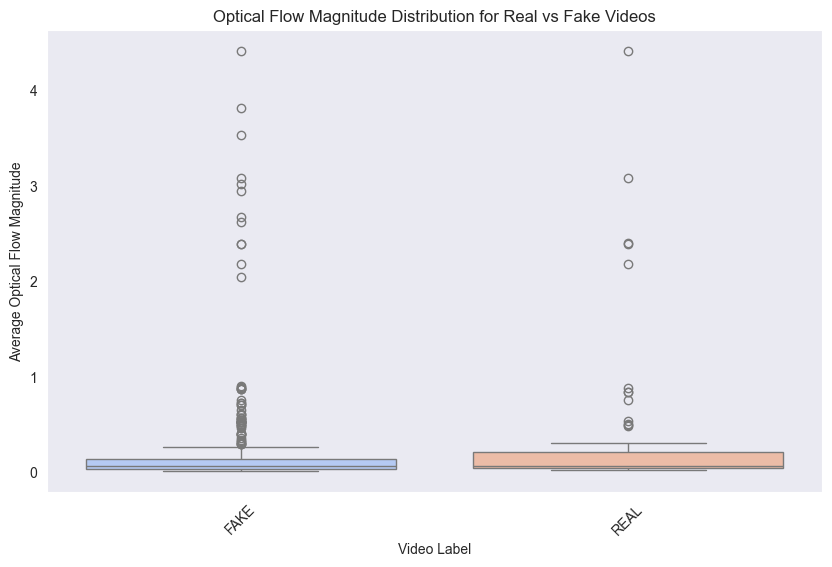

In [33]:
# Visualize the results
visualize_optical_flow_distribution(flow_df)

As seen from the boxplot above, there isn't too much difference between the fake and real videos. Looking back retrospectively, it is most probably due to the fact identified earlier regarding differences being concentrated around the facial region, accounting only for a small subset each frame.

### Concluding remarks for Preliminary EDA

Our exploratory data analysis (EDA) confirms that the primary distinction between real and fake videos lies in alterations within the facial regions. This insight provides a foundation for our feature engineering process. We will utilize the YOLO (You Only Look Once) algorithm to extract faces from each video, which will help reduce file sizes. This reduction in data volume will facilitate the training and development of predictive models, allowing for more efficient processing.

### Embedding Visualization

In [6]:
# Load a pre-trained Vision Transformer model
model = models.vit_b_16(pretrained=True)
model.eval()

# Define a transformation to preprocess the frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to 224x224 as ViT typically expects this size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for ViT
])

def extract_video_features(video_path, duration=10):
    """Extract average features from a video using a pre-trained model."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(frame_rate * duration)
    frame_count = 0

    while cap.isOpened() and frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Preprocess the frame
        frame_tensor = preprocess(frame)
        frames.append(frame_tensor)
        frame_count += 1

    cap.release()

    # Stack the frames and pass through the model
    if frames:
        # Stack the frames into a 4D tensor: (num_frames, channels, height, width)
        frames_tensor = torch.stack(frames)  # Shape: (num_frames, channels, height, width)

        # Prepare a list to hold features for each frame
        all_features = []

        with torch.no_grad():
            for frame_tensor in frames_tensor:
                # Add batch dimension for the model
                frame_tensor = frame_tensor.unsqueeze(0)  # Shape: (1, channels, height, width)

                # Pass the single frame through the model
                features = model(frame_tensor)  # This will output the features for the single frame
                all_features.append(features)

        # Convert the list of features to a single tensor and average them
        all_features_tensor = torch.cat(all_features, dim=0)  # Shape: (num_frames, feature_dim)
        avg_features = all_features_tensor.mean(dim=0).numpy()  # Average across frames and convert to NumPy
        return avg_features

    return None

def process_videos_features(df, video_dir, duration=10):
    """Process all videos to extract features."""
    feature_data = []

    for idx, row in df.iterrows():
        video_file = row['video_filename']
        video_label = row['label']
        video_path = os.path.join(video_dir, video_file)

        # Extract video features
        features = extract_video_features(video_path, duration)

        # Ensure features are correctly extracted
        if features is not None and features.ndim == 1:  # Check if features is a 1D array
            feature_data.append({'video': video_file, 'label': video_label, 'features': features})
        else:
            print(f"Warning: Features not extracted properly for {video_file}. Features: {features}")

    return pd.DataFrame(feature_data)

C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jhau2\.virtualenvs\dsa4266-project-thxkCpQA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def visualize_embeddings_3d(flow_df, info_df):
    """Visualize the embeddings in 3D with unique colors and shapes for each original video cluster."""
    # Merge flow_df with info_df on video_filename
    merged_df = pd.merge(flow_df, info_df, left_on='video', right_on='video_filename', how='left')

    # Extract features and labels
    embeddings = np.array(merged_df['features'].tolist())
    originals = merged_df['original'].fillna(merged_df['video_filename']).values  # Treat REAL videos as their own original

    # Create a limited colour palette: assign a unique color to each original video
    unique_originals = np.unique(originals)
    base_colors = plt.cm.get_cmap('tab10', len(unique_originals))  # Using a color map with a limited set of colors
    original_color_map = {orig: base_colors(i) for i, orig in enumerate(unique_originals)}

    # Prepare for plotting
    video_colors = []
    video_shapes = []

    for i, row in merged_df.iterrows():
        base_color = original_color_map[row['original']] if pd.notna(row['original']) else original_color_map[row['video_filename']]

        # Assign shape based on the label
        if row['label_x'] == 'FAKE':
            video_shapes.append('^')  # Triangle for fake videos
            color_with_alpha = to_rgba(base_color, alpha=0.4)  # Lighter shade for fake
        else:
            video_shapes.append('o')  # Circle for real videos
            color_with_alpha = to_rgba(base_color, alpha=1.0)  # Opaque color for real

        video_colors.append(color_with_alpha)

    # Perform t-SNE for dimensionality reduction (3D)
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # Plot the results in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, (x, y, z) in enumerate(tsne_results):
        ax.scatter(x, y, z, color=video_colors[i], marker=video_shapes[i], alpha=0.8)

    # Add legend: Map each original to its color and shape
    handles = []
    for orig in unique_originals:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=orig,
                                  markerfacecolor=original_color_map[orig], markersize=10))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label='REAL', markerfacecolor='k', markersize=10))
    handles.append(plt.Line2D([0], [0], marker='^', color='w', label='FAKE', markerfacecolor='k', markersize=10))

    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Original Videos/Labels')

    ax.set_title('3D t-SNE Visualization of Video Embeddings')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.grid(True)
    plt.show()

In [81]:
train_faces_videos_path = '../data/face_videos'
flow_df = process_videos_features(train_metadata_df, train_faces_videos_path)

In [82]:
# File path
file_path = "data.csv"

# Check if file exists
if os.path.exists(file_path):
    # Append without header if file exists
    flow_df.to_csv(file_path, mode='a', index=False, header=False)
else:
    # Create file with header if it doesn't exist
    flow_df.to_csv(file_path, mode='w', index=False)

In [12]:
# Step 1: Load the DataFrame from CSV
flow_df = pd.read_csv("data.csv")

# Step 2: Clean and convert the 'embedding' column from string to NumPy arrays
def parse_array(array_str):
    # Remove brackets and any extra spaces/newlines
    clean_str = array_str.replace('\n', ' ').replace('[', '').replace(']', '')

    # Convert the cleaned string to a NumPy array of floats
    return np.array([float(x) for x in clean_str.split()])

# Apply the conversion to the 'embedding' column
flow_df['features'] = flow_df['features'].apply(parse_array)

# Verify the result
print(flow_df.head())

            video label                                           features
0  aagfhgtpmv.mp4  FAKE  [1.23141646, 0.0737621933, -1.19419932, -0.207...
1  aapnvogymq.mp4  FAKE  [-0.215604663, -0.561435223, -0.192221582, -0....
2  abarnvbtwb.mp4  REAL  [0.715067863, -0.449277848, -1.00983214, -0.86...
3  abofeumbvv.mp4  FAKE  [0.34509626, 0.0822542533, 0.340434104, -0.017...
4  abqwwspghj.mp4  FAKE  [-0.298554152, 0.781098008, -0.860464334, -0.6...


C:\Users\jhau2\AppData\Local\Temp\ipykernel_24704\3863995314.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10', len(unique_originals))  # Using a color map with a limited set of colors


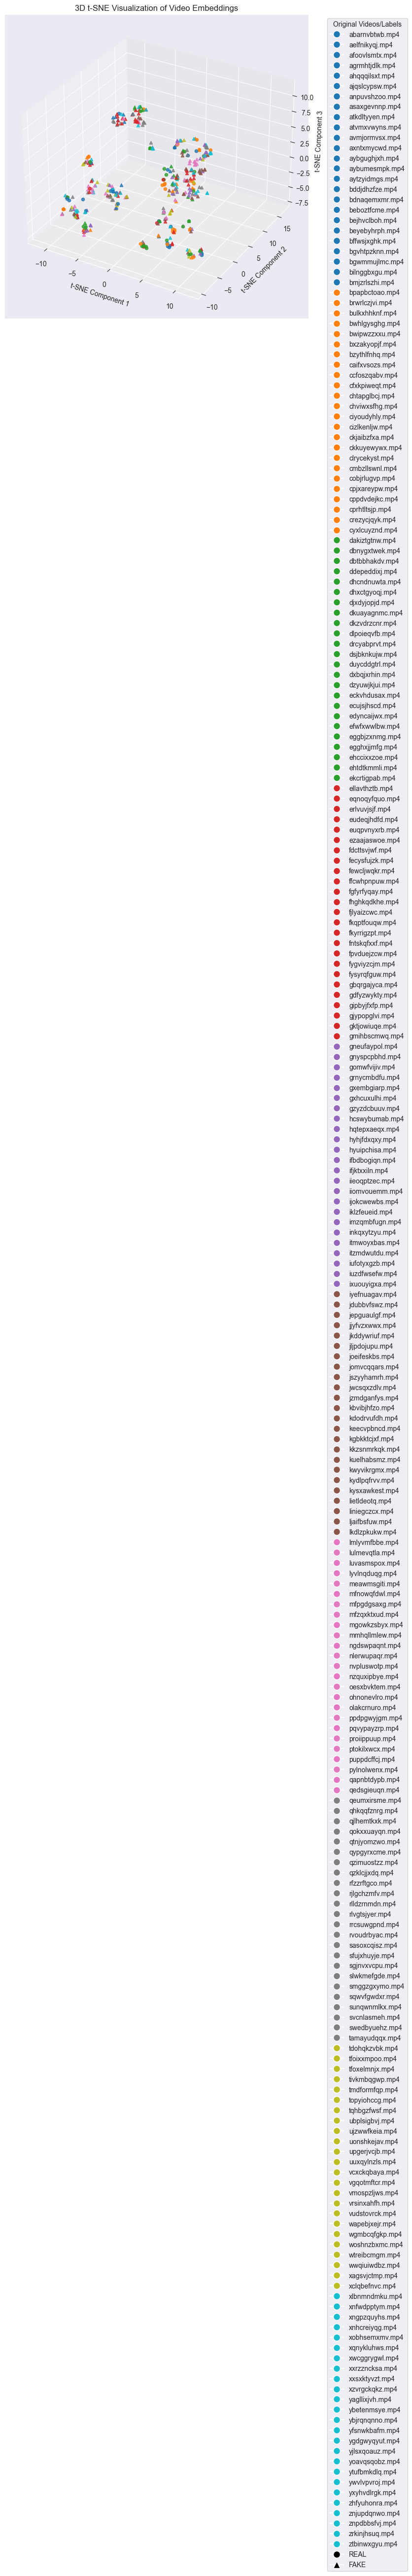

In [13]:
visualize_embeddings_3d(flow_df, train_metadata_df)